In [1]:
# libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.linalg import svd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import MSTL

In [2]:
# Read and preprocess the data
energy_data = pd.read_csv("NI_hourly.csv")
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])
energy_data['hour'] = energy_data['Datetime'].dt.hour
energy_data['date'] = energy_data['Datetime'].dt.date

# Sort chronologically by Datetime
energy_data = energy_data.sort_values('Datetime')

Data range: 2004-05-01 01:00:00 to 2011-01-01 00:00:00


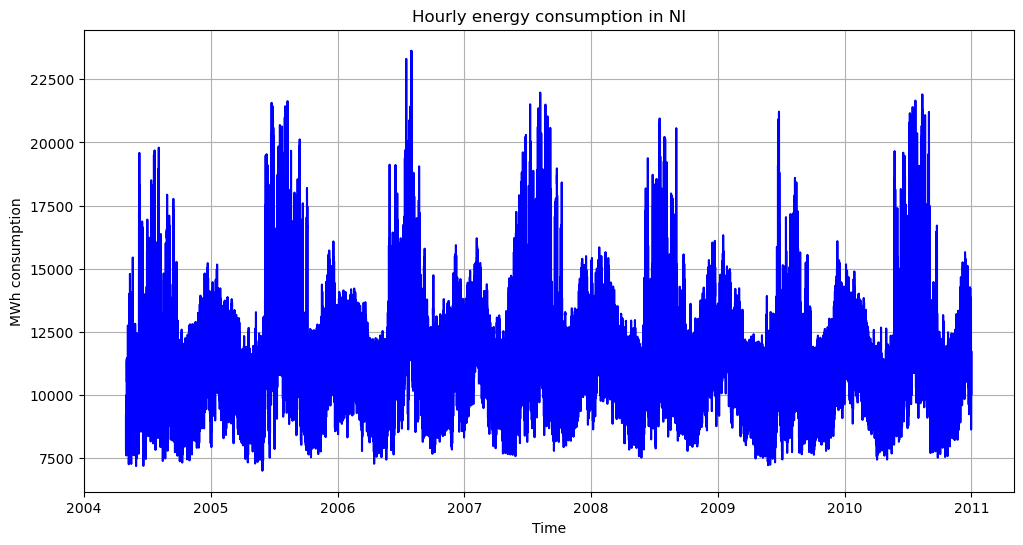

In [3]:
# Display data range
print(f"Data range: {energy_data['Datetime'].min()} to {energy_data['Datetime'].max()}")

# Plot hourly consumption
plt.figure(figsize=(12, 6))
plt.plot(energy_data['Datetime'], energy_data['NI_MW'], color='blue')
plt.xlabel('Time')
plt.ylabel('MWh consumption')
plt.title('Hourly energy consumption in NI')
plt.grid(True)
plt.show()

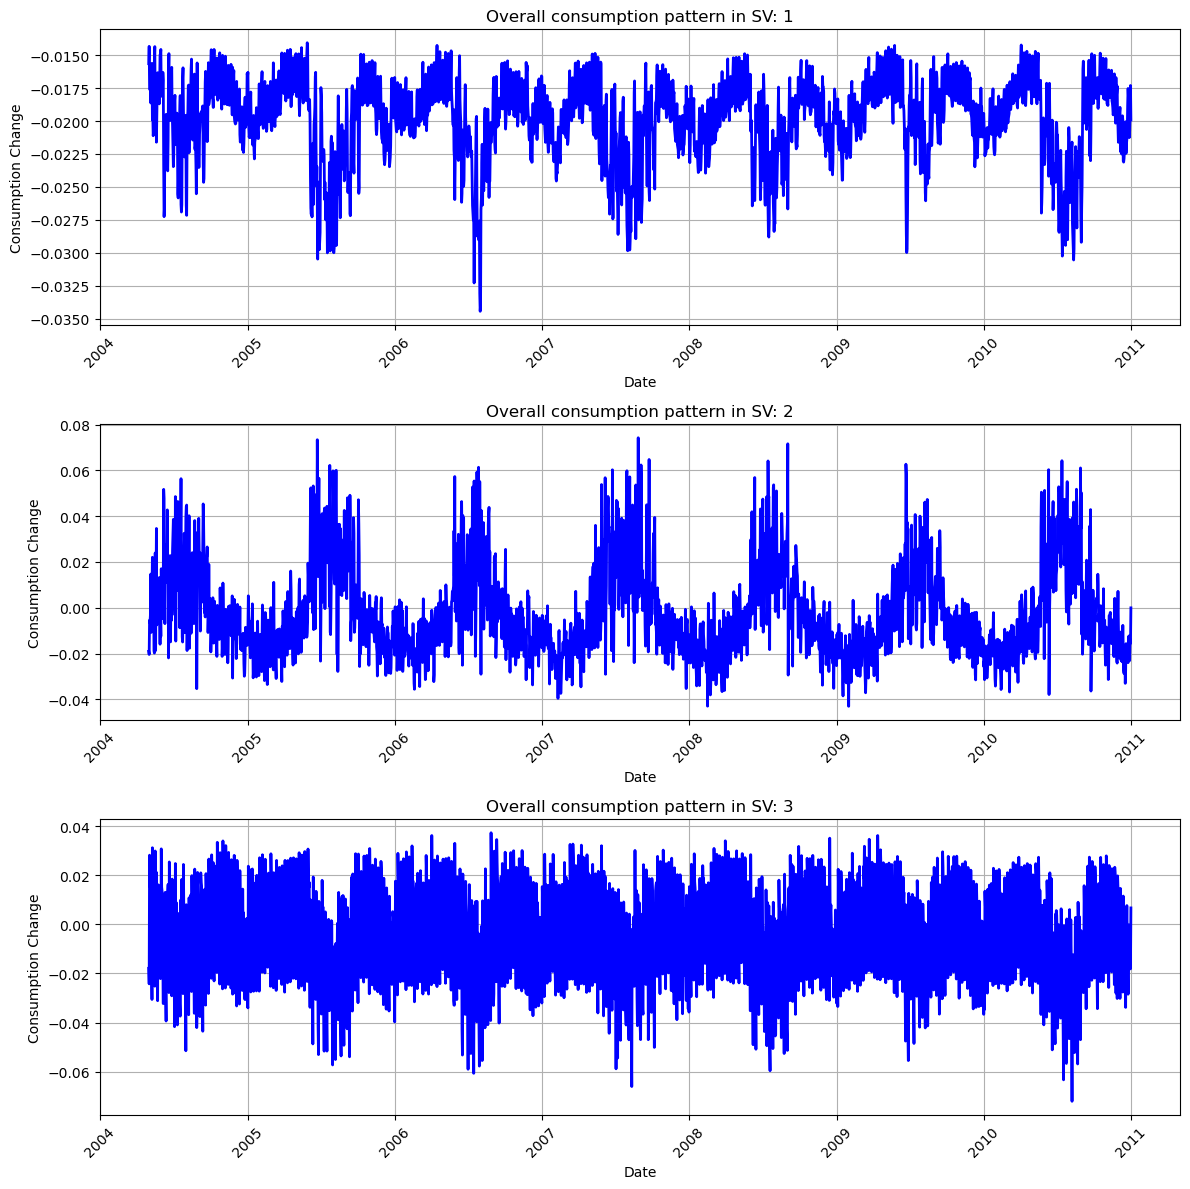

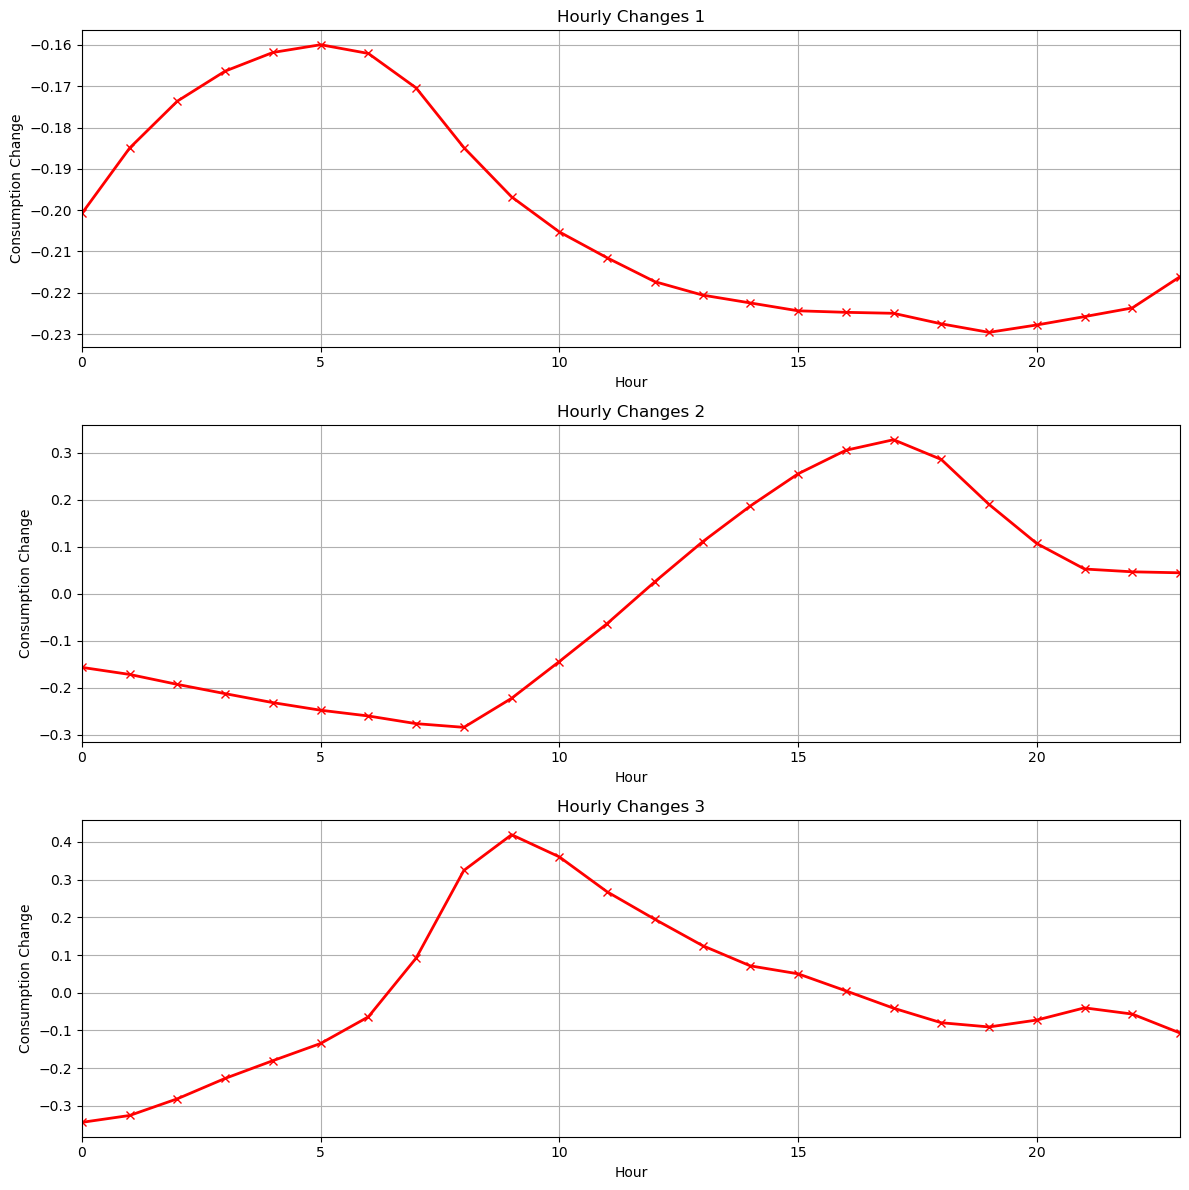

In [4]:
# Create pivot table for SVD analysis
pivoted_data = energy_data.pivot_table(
    values='NI_MW', 
    index='date',
    columns='hour',
    aggfunc='mean'
)
pivoted_data = pivoted_data.fillna(pivoted_data.mean())
matrix = pivoted_data.values

# Perform SVD
U, S, Vt = svd(matrix, full_matrices=False)
V = Vt.T

# Plot overall consumption patterns from SVD
plt.figure(figsize=(12, 12))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(pivoted_data.index, U[:, i], linewidth=2, color='blue')
    plt.title(f'Overall consumption pattern in SV: {i+1}')
    plt.xlabel('Date')
    plt.ylabel('Consumption Change')
    plt.grid(True)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot hourly patterns from SVD
plt.figure(figsize=(12, 12))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(range(24), V[:, i], 'rx-', linewidth=2)
    plt.title(f'Hourly Changes {i+1}')
    plt.xlabel('Hour')
    plt.ylabel('Consumption Change')
    plt.xlim(0, 23)
    plt.grid(True)
plt.tight_layout()
plt.show()

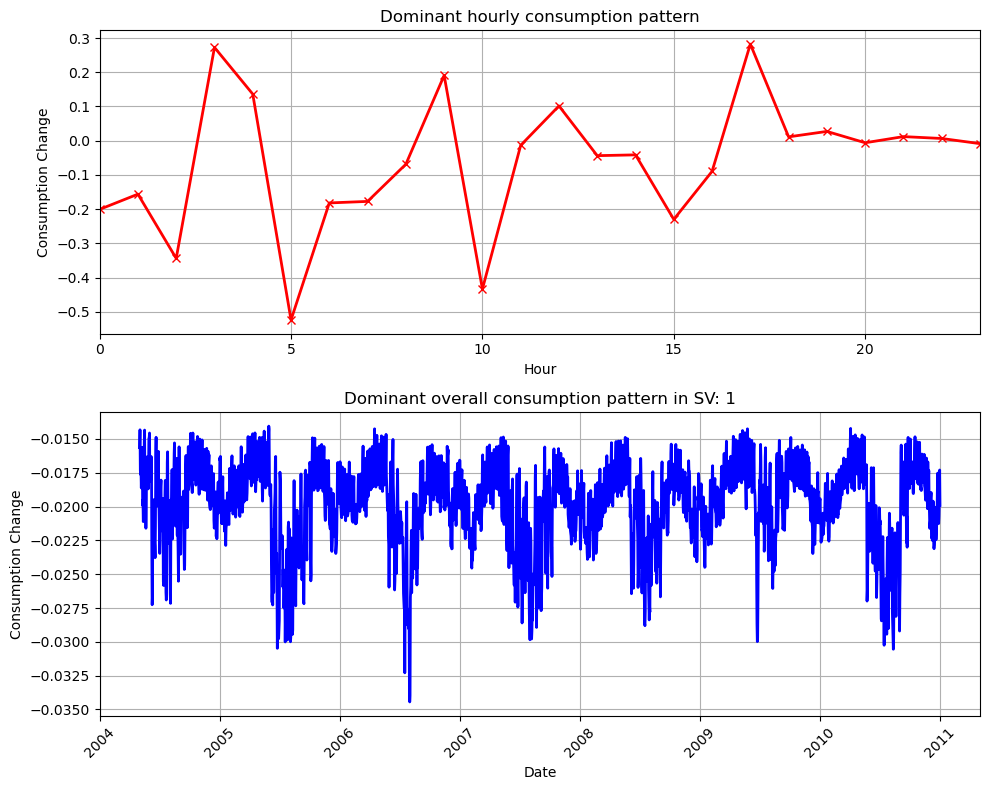

In [5]:
# Create figure with 2 subplots arranged vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# First subplot
hours = np.arange(24)  # 0:23
ax1.plot(hours, V[0, :], 'rx-', linewidth=2)
ax1.set_title('Dominant hourly consumption pattern')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Consumption Change')
ax1.set_xlim([0, 23])
ax1.grid(True)

# Second subplot
ax2.plot(pivoted_data.index, U[:, 0], linewidth=2, color='blue')  # Fixed this line
ax2.set_title(f'Dominant overall consumption pattern in SV: {1}')
ax2.set_xlabel('Date')
ax2.set_ylabel('Consumption Change')
plt.setp(ax2.xaxis.get_ticklabels(), rotation=45)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

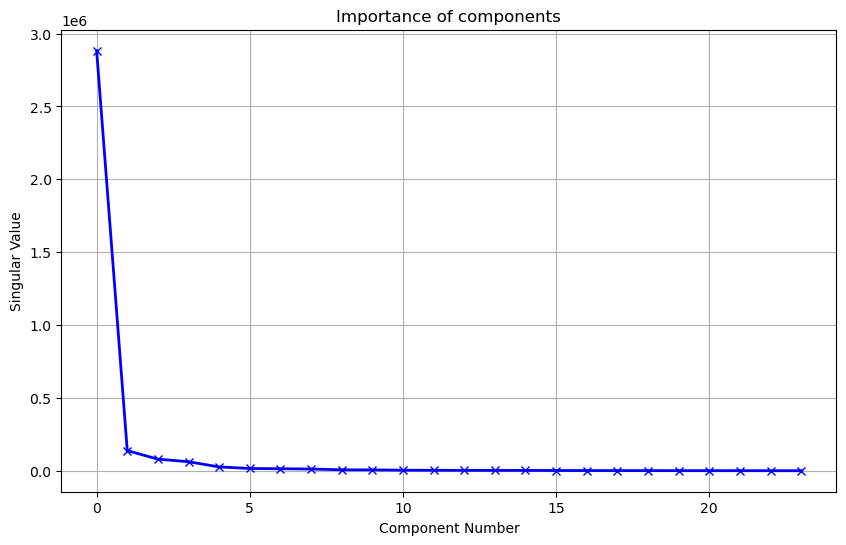

In [6]:
# Plot singular values
plt.figure(figsize=(10, 6))
plt.plot(S, 'bx-', linewidth=2)
plt.xlabel('Component Number')
plt.ylabel('Singular Value')
plt.title('Importance of components')
plt.grid(True)
plt.show()

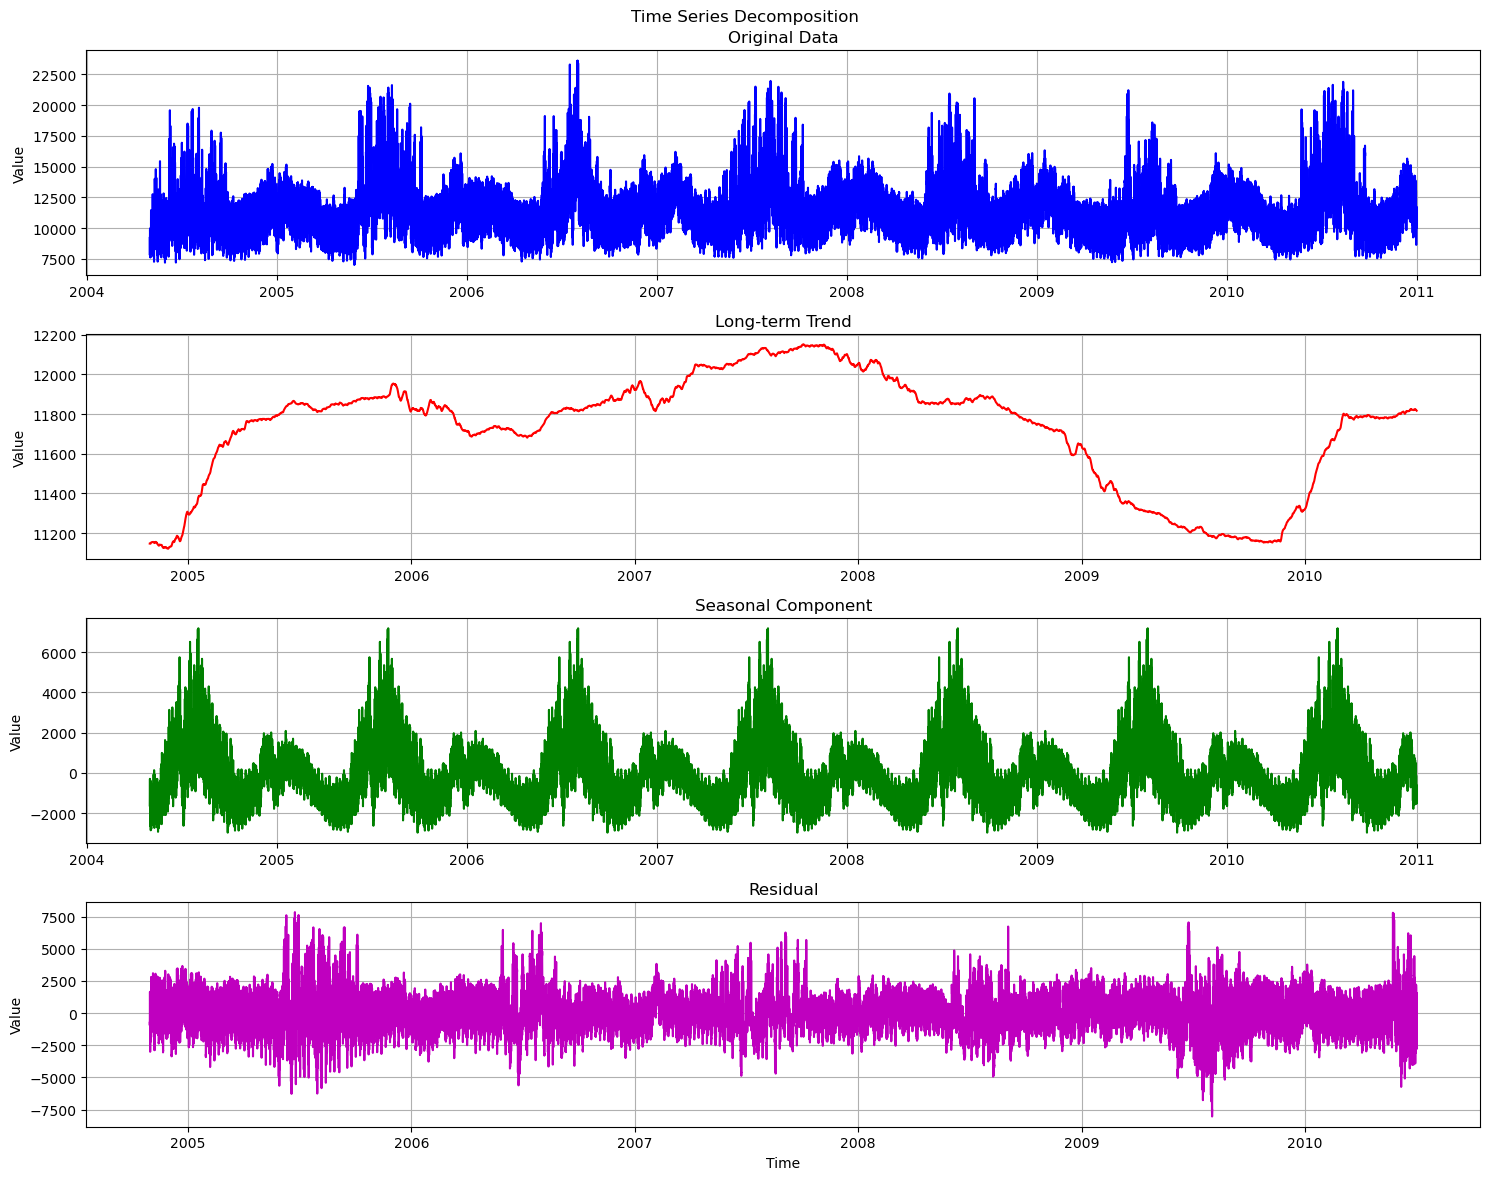

In [7]:
# Time series decomposition
ts_data = pd.Series(
    energy_data['NI_MW'].values,
    index=pd.DatetimeIndex(energy_data['Datetime']),
    name='NI_MW'
)
ts_data = ts_data.sort_index()

# Perform decomposition
decomposition = seasonal_decompose(
    ts_data,
    model="additive",
    period=24*365, # yearly seasonality
    extrapolate_trend=0
)

# Plot decomposition results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Original Data
ax1.plot(ts_data.index, ts_data.values, 'b-', linewidth=1.5)
ax1.set_title('Original Data')
ax1.grid(True)
ax1.set_ylabel('Value')

# Trend
ax2.plot(ts_data.index, decomposition.trend, 'r-', linewidth=1.5)
ax2.set_title('Long-term Trend')
ax2.grid(True)
ax2.set_ylabel('Value')

# Seasonal
ax3.plot(ts_data.index, decomposition.seasonal, 'g-', linewidth=1.5)
ax3.set_title('Seasonal Component')
ax3.grid(True)
ax3.set_ylabel('Value')

# Residual
ax4.plot(ts_data.index, decomposition.resid, 'm-', linewidth=1.5)
ax4.set_title('Residual')
ax4.grid(True)
ax4.set_xlabel('Time')
ax4.set_ylabel('Value')

# Adjust layout for decomposition plot
plt.suptitle('Time Series Decomposition')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

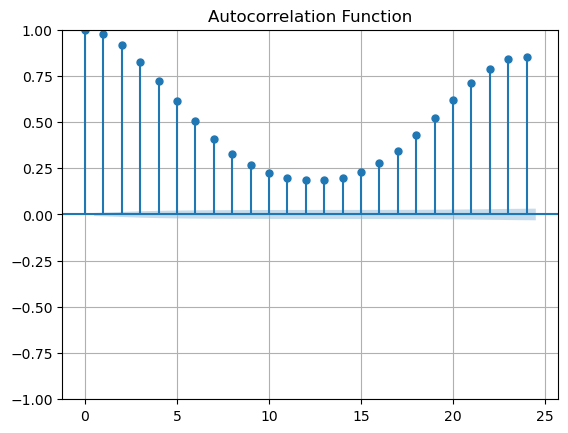

In [8]:
# Plot autocorrelation
plt.figure(figsize=(10, 6))
plot_acf(energy_data['NI_MW'], lags=24)
plt.grid(True)
plt.title('Autocorrelation Function')
plt.show()

Submission 2

In [9]:
# data statistics

print("Analyzing time steps...")

# Sort by datetime and calculate time differences
energy_data = energy_data.sort_values('Datetime')
time_diffs = energy_data['Datetime'].diff()

# Get unique time differences
unique_diffs = time_diffs.unique()
unique_diffs = unique_diffs[~pd.isnull(unique_diffs)]

print("Unique time differences found:")
for diff in unique_diffs:
    count = len(time_diffs[time_diffs == diff])
    print(f"- {diff}: {count} occurrences")

# Analyze missing values
print("\nMissing values per column:")
missing_values = energy_data.isnull().sum()


for col in energy_data.columns:
    print(f"{col}: {missing_values[col]}")


Analyzing time steps...
Unique time differences found:
- 0 days 01:00:00: 58435 occurrences
- 0 days 02:00:00: 14 occurrences

Missing values per column:
Datetime: 0
NI_MW: 0
hour: 0
date: 0


In [12]:
print("Analyzing time steps...")

# Sort by datetime and calculate time differences
energy_data = energy_data.sort_values('Datetime')
time_diffs = energy_data['Datetime'].diff()

# Get unique time differences
unique_diffs = time_diffs.unique()
unique_diffs = unique_diffs[~pd.isnull(unique_diffs)]

print("Unique time differences found:")
for diff in unique_diffs:
    count = len(time_diffs[time_diffs == diff])
    print(f"- {diff}: {count} occurrences")

# Find rows where time diff is 2 hours 
two_hour_mask = time_diffs == pd.Timedelta(hours=2)

print("\nTwo hour time steps found:")
for prev, curr in zip(energy_data['Datetime'].shift()[two_hour_mask], 
                     energy_data['Datetime'][two_hour_mask]):
    print(f"Gap between {prev} and {curr}")

# Analyze missing values
print("\nMissing values per column:")
missing_values = energy_data.isnull().sum()

for col in energy_data.columns:
    print(f"{col}: {missing_values[col]}")

Analyzing time steps...
Unique time differences found:
- 0 days 01:00:00: 58435 occurrences
- 0 days 02:00:00: 14 occurrences

Two hour time steps found:
Gap between 2004-10-31 01:00:00 and 2004-10-31 03:00:00
Gap between 2005-04-03 02:00:00 and 2005-04-03 04:00:00
Gap between 2005-10-30 01:00:00 and 2005-10-30 03:00:00
Gap between 2006-04-02 02:00:00 and 2006-04-02 04:00:00
Gap between 2006-10-29 01:00:00 and 2006-10-29 03:00:00
Gap between 2007-03-11 02:00:00 and 2007-03-11 04:00:00
Gap between 2007-11-04 01:00:00 and 2007-11-04 03:00:00
Gap between 2008-03-09 02:00:00 and 2008-03-09 04:00:00
Gap between 2008-11-02 01:00:00 and 2008-11-02 03:00:00
Gap between 2009-03-08 02:00:00 and 2009-03-08 04:00:00
Gap between 2009-11-01 01:00:00 and 2009-11-01 03:00:00
Gap between 2010-03-14 02:00:00 and 2010-03-14 04:00:00
Gap between 2010-11-07 01:00:00 and 2010-11-07 03:00:00
Gap between 2010-12-09 23:00:00 and 2010-12-10 01:00:00

Missing values per column:
Datetime: 0
NI_MW: 0
hour: 0
date: